In [1]:
import pyemma
import pickle
import os
import glob
import torch

import mdtraj as md
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go


np.bool = np.bool_

from tqdm import tqdm
from matplotlib.colors import LogNorm
from itertools import combinations

blue = (70 / 255, 110 / 255, 250 / 255)
green = (100 / 255, 170 / 255, 120 / 255)

molecule = "CLN025"
simulation_idx = 0
base_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-protein"
save_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein"
pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb"

# Visualization

In [2]:
print(pdb_path)
pdb_traj = md.load_pdb(pdb_path)
print(pdb_traj)
pdb_view = nv.show_mdtraj(pdb_traj)
pdb_view.add_representation("licorice", selection="protein")
pdb_view

/home/shpark/prj-mlcv/lib/DESRES/data/CLN025/CLN025_from_mae.pdb
<mdtraj.Trajectory with 1 frames, 166 atoms, 10 residues, without unitcells>


NGLWidget()

In [3]:
# Count the number of .dcd files in the simulation directory
dcd_pattern = f"{base_dir}/{molecule}-{simulation_idx}-protein-*.dcd"
dcd_files = glob.glob(dcd_pattern)
num_files = len(dcd_files)

print(f"Found {num_files} .dcd files in {base_dir}")
print(f"Pattern used: {dcd_pattern}")

# Extract the indices from filenames and sort them
file_indices = []
for file_path in dcd_files:
    filename = os.path.basename(file_path)
    # Extract the index from filename like "2JOF-0-protein-000.dcd"
    index_part = filename.split('-')[-1].replace('.dcd', '')
    if index_part.isdigit():
        file_indices.append(int(index_part))

file_indices.sort()
print(f"File indices range: {min(file_indices)} to {max(file_indices)}")
print(f"Total files to load: {len(file_indices)}")

Found 54 .dcd files in /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-0-protein/CLN025-0-protein
Pattern used: /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-0-protein/CLN025-0-protein/CLN025-0-protein-*.dcd
File indices range: 0 to 53
Total files to load: 54


In [4]:
# Load trajectories using the actual file indices found
traj_list = []
for i in tqdm(
    file_indices,
    desc="Loading trajectories"
):
    file_idx = f"{i:03d}"
    file_path = f"{base_dir}/{molecule}-{simulation_idx}-protein-{file_idx}.dcd"
    # print(file_path)
    # Check if file exists before loading
    if os.path.exists(file_path):
        traj = md.load_dcd(file_path, top=pdb_path)
        traj_list.append(traj)
    else:
        print(f"Warning: File not found: {file_path}")

print(f"Successfully loaded {len(traj_list)} trajectory files")
all_traj = md.join(traj_list)

Loading trajectories: 100%|██████████| 54/54 [00:01<00:00, 31.22it/s]


Successfully loaded 54 trajectory files


In [5]:
view = nv.show_mdtraj(all_traj)
view.add_representation("licorice", selection="protein")
view

NGLWidget(max_frame=534742)

In [6]:
view.frame = 0

In [7]:
# bond_num_distance_angle = torch.load("/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-0-protein/CLN025-0-bond_num_distance_angle.pt").numpy()
# print(np.where(bond_num_distance_angle == 6)[0])

In [8]:
# all_traj[view.frame].save_pdb("folded_0bond.pdb")

# Descriptors

In [9]:
pdb = md.load(pdb_path)
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(pdb.topology.residues), 2)]
)
ca_pair_contacts, resid_pairs = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)

print(ca_pair_contacts.shape)
print(ca_pair_contacts.mean())
# torch.save(torch.from_numpy(ca_pair_contacts), f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad.pt")

(534743, 45)
0.7385197


In [10]:
ca_atoms = [atom for atom in all_traj.topology.atoms if atom.name == "CA"]

# Extract their indices
ca_indices = [atom.index for atom in ca_atoms]

print("Alpha carbon indices:", ca_indices)
cnt = 1
for i in range(len(ca_indices)):
    for j in range(i+1, len(ca_indices)):
        print(f"d{cnt}: DISTANCE ATOMS={ca_indices[i]+1},{ca_indices[j]+1}")
        cnt += 1

Alpha carbon indices: [4, 25, 46, 60, 72, 87, 101, 108, 122, 149]
d1: DISTANCE ATOMS=5,26
d2: DISTANCE ATOMS=5,47
d3: DISTANCE ATOMS=5,61
d4: DISTANCE ATOMS=5,73
d5: DISTANCE ATOMS=5,88
d6: DISTANCE ATOMS=5,102
d7: DISTANCE ATOMS=5,109
d8: DISTANCE ATOMS=5,123
d9: DISTANCE ATOMS=5,150
d10: DISTANCE ATOMS=26,47
d11: DISTANCE ATOMS=26,61
d12: DISTANCE ATOMS=26,73
d13: DISTANCE ATOMS=26,88
d14: DISTANCE ATOMS=26,102
d15: DISTANCE ATOMS=26,109
d16: DISTANCE ATOMS=26,123
d17: DISTANCE ATOMS=26,150
d18: DISTANCE ATOMS=47,61
d19: DISTANCE ATOMS=47,73
d20: DISTANCE ATOMS=47,88
d21: DISTANCE ATOMS=47,102
d22: DISTANCE ATOMS=47,109
d23: DISTANCE ATOMS=47,123
d24: DISTANCE ATOMS=47,150
d25: DISTANCE ATOMS=61,73
d26: DISTANCE ATOMS=61,88
d27: DISTANCE ATOMS=61,102
d28: DISTANCE ATOMS=61,109
d29: DISTANCE ATOMS=61,123
d30: DISTANCE ATOMS=61,150
d31: DISTANCE ATOMS=73,88
d32: DISTANCE ATOMS=73,102
d33: DISTANCE ATOMS=73,109
d34: DISTANCE ATOMS=73,123
d35: DISTANCE ATOMS=73,150
d36: DISTANCE ATOMS=88

In [11]:
ca_pair_contacts_switch = (1 - np.power(ca_pair_contacts / 0.8, 6)) / (1 - np.power(ca_pair_contacts / 0.8, 12))
print(ca_pair_contacts_switch.shape)
print(ca_pair_contacts_switch.mean())
# torch.save(torch.from_numpy(ca_pair_contacts_switch), f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad-switch.pt")

(534743, 45)
0.6254336


In [12]:
xyz = all_traj.xyz
print(xyz.shape)

# torch.save(torch.from_numpy(xyz), f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos.pt")

(534743, 166, 3)


# TICA

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


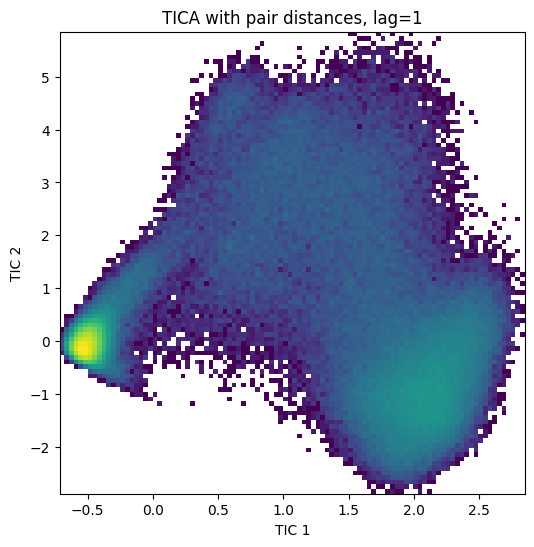

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


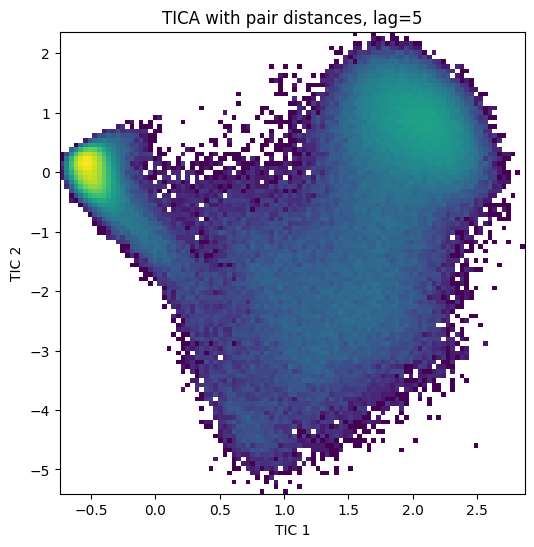

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


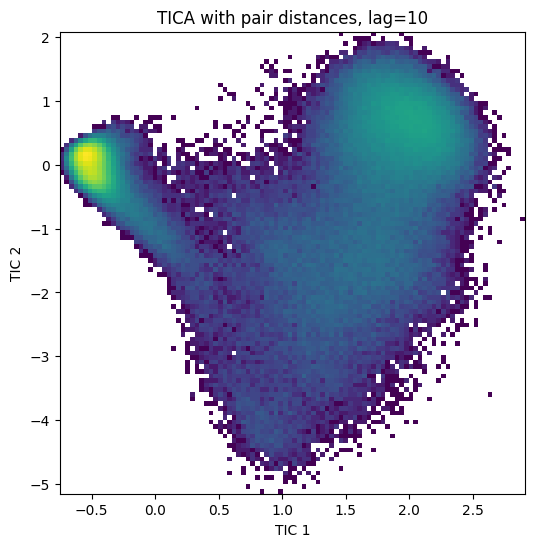

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


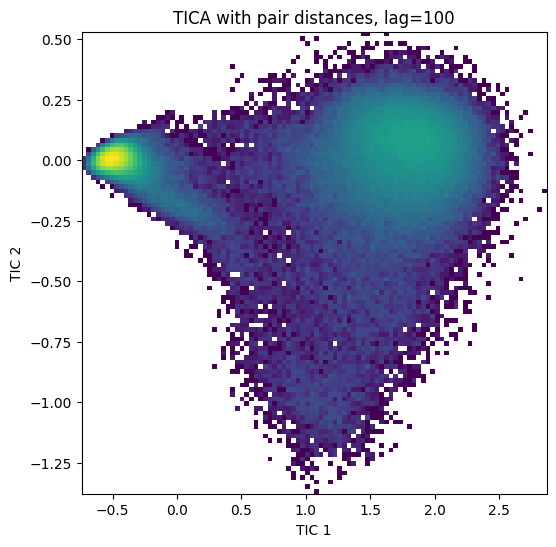

In [ ]:
# TICA with pair distances
for lag in (1, 5, 10, 100):
	data = ca_pair_contacts
	tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
	tica_data = tica_obj.get_output()[0]
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	# State information
	# state_traj = md.load(pdb_path)
	# state_ca_pair_contacts, resid_pairs = md.compute_contacts(
	# 	state_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
	# )
	# tica_state = tica_obj.transform(state_ca_pair_contacts)

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances, lag={lag}")
	plt.savefig(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


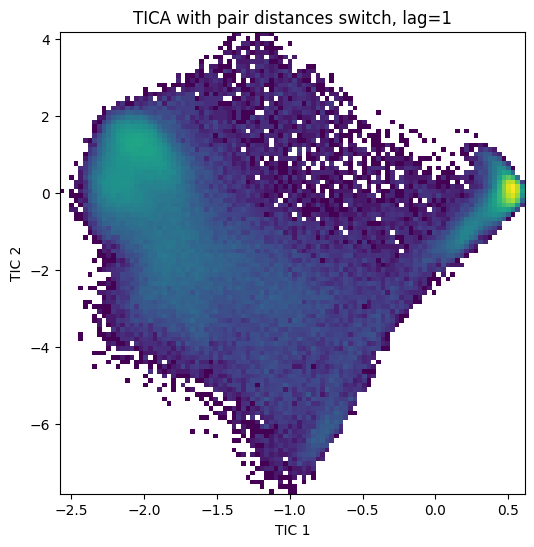

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


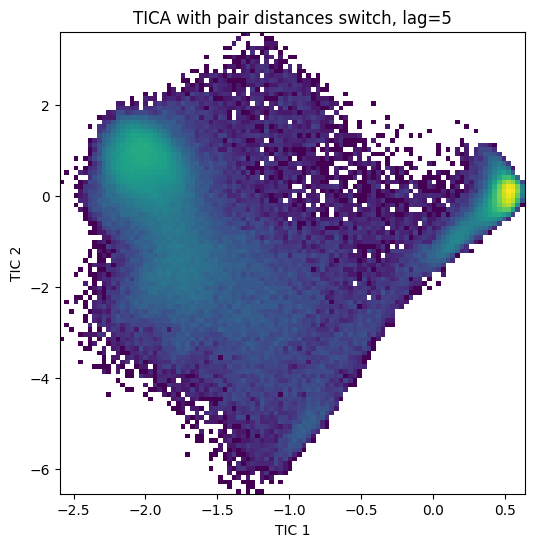

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


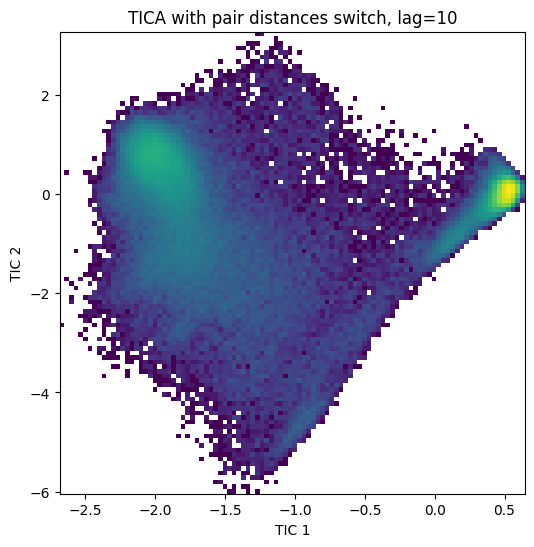

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


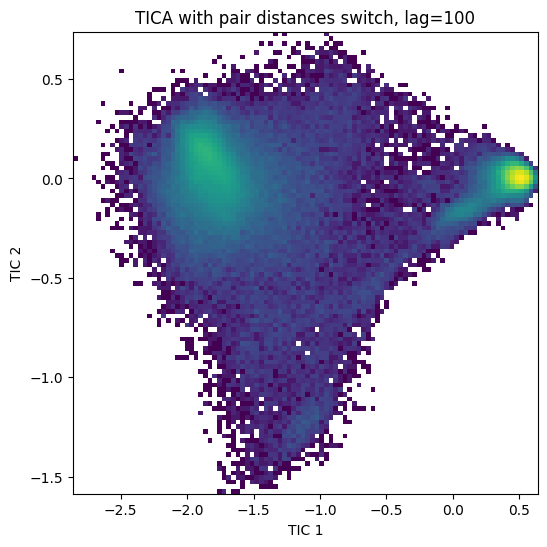

In [ ]:
# TICA with pair distances switch
for lag in (1, 5, 10, 100):
	data = ca_pair_distances_swtich
	tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
	tica_data = tica_obj.get_output()[0]
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	# State information
	# state_traj = md.load(pdb_path)
	# state_ca_pair_contacts, resid_pairs = md.compute_contacts(
	# 	state_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
	# )
	# state_ca_pair_contacts_switch = (1 - np.power(state_ca_pair_contacts / 0.8, 6)) / (1 - np.power(state_ca_pair_contacts / 0.8, 12))
	# tica_state = tica_obj.transform(state_ca_pair_contacts_switch)

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	# ax.scatter(tica_state[:, 0], tica_state[:, 1], c='red', s=10)
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances switch, lag={lag}")
	plt.savefig(f'../data/{molecule}/{molecule}_tica_model_switch_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}/{molecule}_tica_model_switch_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

# Analysis

## Committor

In [11]:
committor_path = "/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-0-protein/committor.pt"
committor_model = torch.jit.load(committor_path, map_location=torch.device(0))
print(committor_model)

RecursiveScriptModule(
  original_name=NN_committor_guess
  (nn): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Tanh)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=Tanh)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=CustomActivation)
  )
)


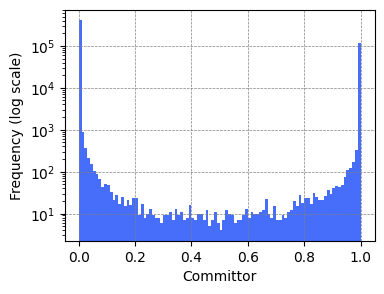

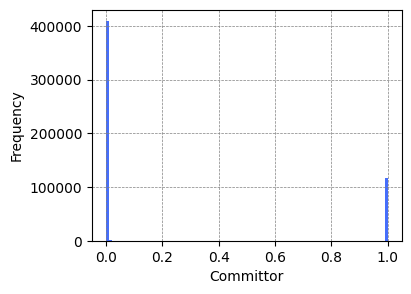

In [ ]:
cad_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-0-protein/CLN025-0-cad.pt"
cad_torch = torch.load(cad_path).to(0)
committor_value = committor_model(cad_torch)

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
plt.hist(
    committor_value.cpu().detach().numpy().flatten(),
    bins=100,
    log=True,
    color=blue,
)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both') 
plt.xlabel("Committor")
plt.ylabel("Frequency (log scale)")
plt.show()

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
plt.hist(
    committor_value.cpu().detach().numpy().flatten(),
    bins=100,
    color=blue,
)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both') 
plt.xlabel("Committor")
plt.ylabel("Frequency")
plt.show()

In [14]:
# TICA Model
lag = 10
TICA_SWITCH = True

class TICA_WRAPPER:
    """TICA wrapper for coordinate transformation."""
    def __init__(self, tica_model_path, pdb_path, tica_switch: bool = False):
        with open(tica_model_path, 'rb') as f:
            self.tica_model = pickle.load(f)
        self.pdb = md.load(pdb_path)
        self.ca_resid_pair = np.array(
            [(a.index, b.index) for a, b in combinations(list(self.pdb.topology.residues), 2)]
        )
        self.tica_switch = tica_switch
        print(f"Loaded TICA model: {self.tica_model}")

    def transform(self, cad_data: np.ndarray):
        if self.tica_switch:
            cad_data = (1 - np.power(cad_data / 0.8, 6)) / (1 - np.power(cad_data / 0.8, 12))
        tica_coord = self.tica_model.transform(cad_data)
        return tica_coord

    def pos2cad(self, pos_data: np.ndarray):
        self.pdb.xyz = pos_data
        ca_pair_distances, _ = md.compute_contacts(
            self.pdb, scheme="ca", contacts=self.ca_resid_pair, periodic=False
        )
        return ca_pair_distances

if TICA_SWITCH:
	tica_model_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_tica_model_switch_lag{lag}.pkl"
else:
	tica_model_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_tica_model_lag{lag}.pkl"         
tica_wrapper = TICA_WRAPPER(
	tica_model_path=tica_model_path,
	pdb_path=f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb",
	tica_switch=TICA_SWITCH
)

Loaded TICA model: TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=10,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)


(530000, 2)


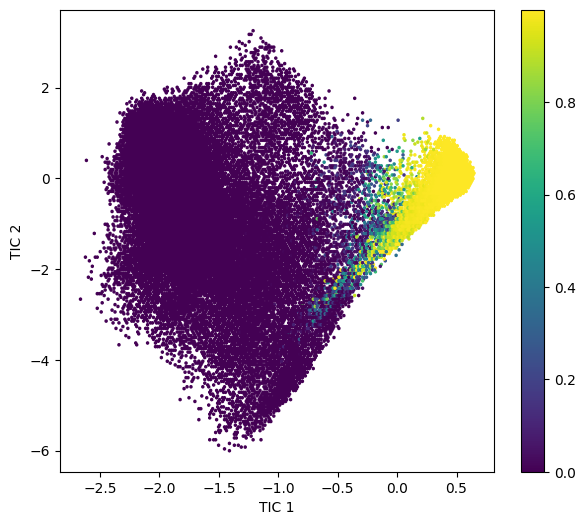

In [15]:
cad_data = cad_torch.cpu().detach().numpy()
tica_data = tica_wrapper.transform(cad_data)
x = tica_data[:, 0]
y = tica_data[:, 1]
print(tica_data.shape)


fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
hb = ax.hexbin(
	x, y, C=1 - committor_value.cpu().detach().numpy().flatten(),
	gridsize=200,                     # controls resolution
	reduce_C_function=np.mean,       # compute average per hexagon
	cmap='viridis',                  # colormap
)
plt.colorbar(hb)
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
plt.show()

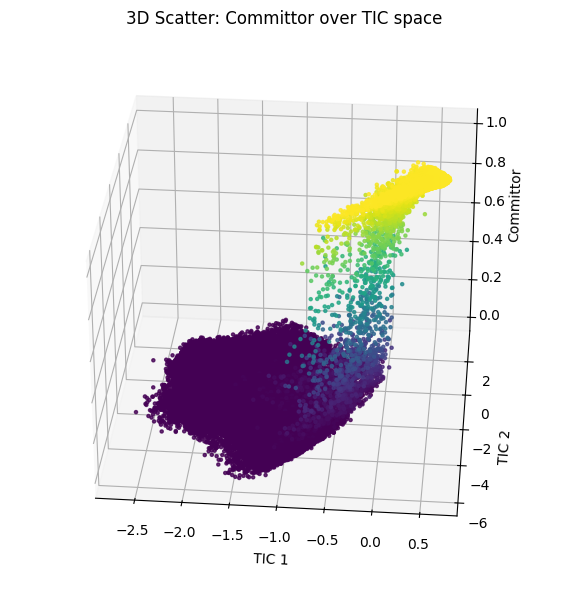

In [16]:
# 3D scatter plot
z = 1 - committor_value.cpu().detach().numpy().flatten()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=5, alpha=0.8)

ax.set_xlabel('TIC 1')
ax.set_ylabel('TIC 2')
ax.set_zlabel(f'Committor')
ax.set_title(f'3D Scatter: Committor over TIC space')
ax.view_init(azim=-85)
# fig.colorbar(sc, ax=ax, label='CV Value')

plt.tight_layout()
plt.show()

In [ ]:
# 3D interactive TICA
z = committor_value.cpu().detach().numpy().flatten()
fig = go.Figure(
	data=go.Scatter3d(
		x=x,
		y=y,
		z=z,
		mode='markers',
		marker=dict(
			size=3,
			color=z,
			colorscale='Viridis',
			colorbar=dict(title=f'Committor'),
			opacity=0.8
		)
	)
)

fig.update_layout(
	scene=dict(
		xaxis_title='TIC 1',
		yaxis_title='TIC 2',
		zaxis_title=f'Committor',
		aspectmode='manual',
  		aspectratio=dict(x=1, y=1, z=1)
	),
	title=f'Committor in TICA Space',
	margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()

## Bond number

In [ ]:
def label_by_hbond(
    traj,
    distance_cutoff=0.35,
    angle_cutoff=110,
    bond_number_cutoff=3
):
	"""
	Generate binary labels for folded/unfolded states based at least 3 bonds among eight bonds
	- TYR1T-YR10OT1
	- TYR1T-YR10OT2
	- ASP3N-TYR8O
	- THR6OG1-ASP3O
	- THR6N-ASP3OD1
	- THR6N-ASP3OD2
	- TYR10N-TYR1O


	Args:
		traj (mdtraj): mdtraj trajectory object
		distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 amstrong)
		angle_cutoff (float): hydrogen bond angle cutoff in degrees (default 110 deg)
		bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

	Returns:
		labels (np.array): binary array (1: folded, 0: unfolded)
	"""
	distances = []
	# TYR1N-YR10OT1
	print(f"Bond: TYR1N-YR10OT1 (1/8)")
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	hydrogen_idx, hydrogen_idx, hydrogen_idx_3 = 1, 2, 3   # Tyr10:H
	acceptor_idx = traj.topology.select('residue 10 and name O')[0]   # Tyr10:OT1
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	angle_2 = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	angle_3 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_3, acceptor_idx]]) * (180.0 / np.pi)
	label_O1 = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff) & (angle_2[:,0] > angle_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff) & (angle_3[:,0] > angle_cutoff)).astype(int)
	label_TYR1N_TYR10OT1 = label_O1 | label_O2 | label_O3
	distances.append(distance[:, 0])


	# TYR1N-YR10OT2
	print(f"Bond: TYR1N-YR10OT2 (2/8)")
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	hydrogen_idx_1, hydrogen_idx_2, hydrogen_idx_3 = 1, 2, 3   # Tyr10:H
	acceptor_idx = traj.topology.select('residue 10 and name OXT')[0]   # Tyr10:OT2
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle_1 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_1, acceptor_idx]]) * (180.0 / np.pi)
	angle_2 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_2, acceptor_idx]]) * (180.0 / np.pi)
	angle_3 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_3, acceptor_idx]]) * (180.0 / np.pi)
	label_O1 = ((distance[:,0] < distance_cutoff) & (angle_1[:,0] > angle_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff) & (angle_2[:,0] > angle_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff) & (angle_3[:,0] > angle_cutoff)).astype(int)
	label_TYR1N_TYR10OT2 = label_O1 | label_O2 | label_O3
	distances.append(distance[:, 0])


	# ASP3N-TYR8O
	print(f"Bond: ASP3N-TYR8O (3/8)")
	donor_idx = traj.topology.select('residue 3 and name N')[0]
	hydrogen_idx = 45
	acceptor_idx = traj.topology.select('residue 8 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_ASP3N_TYR8O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
	distances.append(distance[:, 0])


	# THR6OG1-ASP3O
	print(f"Bond: THR6OG1-ASP3O (4/8)")
	donor_idx = traj.topology.select('residue 6 and name OG1')[0]
	hydrogen_idx = 92
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_THR6OG1_ASP3O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
	distances.append(distance[:, 0])


	# THR6N-ASP3OD1
	print(f"Bond: THR6N-ASP3OD1 (5/8)")
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	hydrogen_idx = 86
	acceptor_idx = traj.topology.select('residue 3 and name OD1')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_THR6N_ASP3OD1 = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
	distances.append(distance[:, 0])


	# THR6N-ASP3OD2
	print(f"Bond: THR6N-ASP3OD2 (6/8)")
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	hydrogen_idx = 86
	acceptor_idx = traj.topology.select('residue 3 and name OD2')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_THR6N_ASP3OD2 = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
	distances.append(distance[:, 0])


	# GLY7N-ASP3O
	print(f"Bond: GLY7N-ASP3O (7/8)")
	donor_idx = traj.topology.select('residue 7 and name N')[0]
	hydrogen_idx = 100
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_GLY7N_ASP3O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
	distances.append(distance[:, 0])


	# TYR10N-TYR1O
	print(f"Bond: TYR10N-TYR1O (8/8)")
	donor_idx = traj.topology.select('residue 10 and name N')[0] 
	hydrogen_idx = 145
	acceptor_idx = traj.topology.select('residue 1 and name O')[0] 
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_TYR10N_TYR1O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
	distances.append(distance[:, 0])


	# All bonds
	bond_sum = label_TYR1N_TYR10OT1 + label_TYR1N_TYR10OT2 + labels_ASP3N_TYR8O + labels_THR6OG1_ASP3O \
		+ labels_THR6N_ASP3OD1 + labels_THR6N_ASP3OD2 + labels_GLY7N_ASP3O + labels_TYR10N_TYR1O
	labels = bond_sum >= bond_number_cutoff
	distances = np.array(distances)
 
	# print(label_TYR10OT_TYR1N.sum())
	# print(labels_TYR10N_TYR1O.sum())
	# print(labels_ASP3OD_THR6OG1.sum())
	# print(labels_ASP3N_TYR8O.sum())

	return labels, bond_sum, distances

def label_by_hbond_distance(
    traj,
    distance_cutoff=0.35,
    bond_number_cutoff=3
):
	"""
	Generate binary labels for folded/unfolded states based at least 3 bonds among eight bonds
	- TYR1T-YR10OT1
	- TYR1T-YR10OT2
	- ASP3N-TYR8O
	- THR6OG1-ASP3O
	- THR6N-ASP3OD1
	- THR6N-ASP3OD2
	- TYR10N-TYR1O


	Args:
		traj (mdtraj): mdtraj trajectory object
		distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 amstrong)
		angle_cutoff (float): hydrogen bond angle cutoff in degrees (default 110 deg)
		bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

	Returns:
		labels (np.array): binary array (1: folded, 0: unfolded)
	"""
	# TYR1N-YR10OT1
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name O')[0]   # Tyr10:OT1
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int) 
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT1 = label_O1 | label_O2 | label_O3


	# TYR1N-YR10OT2
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name OXT')[0]   # Tyr10:OT2
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT2 = label_O1 | label_O2 | label_O3


	# ASP3N-TYR8O
	donor_idx = traj.topology.select('residue 3 and name N')[0]
	acceptor_idx = traj.topology.select('residue 8 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_ASP3N_TYR8O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6OG1-ASP3O
	donor_idx = traj.topology.select('residue 6 and name OG1')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6OG1_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6N-ASP3OD1
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD1')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD1 = ((distance[:,0] < distance_cutoff)).astype(int)
 
	# THR6N-ASP3OD2
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD2')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD2 = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# GLY7N-ASP3O
	donor_idx = traj.topology.select('residue 7 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_GLY7N_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 

	# TYR10N-TYR1O
	donor_idx = traj.topology.select('residue 10 and name N')[0] 
	acceptor_idx = traj.topology.select('residue 1 and name O')[0] 
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_TYR10N_TYR1O = ((distance[:,0] < distance_cutoff)).astype(int)

	# ASP3OD_THR6OG1_ASP3N_THR8O
	bond_sum = label_TYR1N_TYR10OT1 + label_TYR1N_TYR10OT2 + label_ASP3N_TYR8O + label_THR6OG1_ASP3O \
		+ label_THR6N_ASP3OD1 + label_THR6N_ASP3OD2 + label_GLY7N_ASP3O + label_TYR10N_TYR1O
	labels = bond_sum >= bond_number_cutoff

	return labels, bond_sum

In [31]:
# label_distance, bond_num_distance = label_by_hbond_distance(all_traj)
# print(label_distance.shape)
# print(bond_num_distance.shape)

label_distance_angle, bond_num_distance_angle, bond_distances = label_by_hbond(all_traj)
print(label_distance_angle.shape)
print(bond_num_distance_angle.shape)

Bond: TYR1N-YR10OT1
Bond: TYR1N-YR10OT2
Bond: ASP3N-TYR8O
Bond: THR6OG1-ASP3O
Bond: THR6N-ASP3OD1
Bond: THR6N-ASP3OD2
Bond: GLY7N-ASP3O
Bond: TYR10N-TYR1O
(534743,)
(534743,)


In [73]:
bond_distances_sum = np.sum(bond_distances, axis=0)
min_idx = np.argmin(bond_distances_sum)
print(min_idx)
print(bond_distances_sum[min_idx])
print(bond_distances_sum.min())

295223
2.5017912
2.5017912


array([ 8.266385 ,  6.9473143,  8.699928 , ..., 11.189272 ,  9.837925 ,
       10.174534 ], shape=(534743,), dtype=float32)

In [22]:
folded_idx = 295223
print(f"Folded: {label_distance_angle[folded_idx]}")
folded_traj = all_traj[folded_idx]
folded_traj.save_pdb("/home/shpark/prj-mlcv/lib/DESRES/data/CLN025/folded.pdb")

folded_view = nv.show_mdtraj(folded_traj)
folded_view.add_representation("licorice", selection="protein")
folded_view

NameError: name 'label_distance_angle' is not defined

In [32]:
# folded_state_distance = label_distance.sum()
# print("Foldedness by H bond distance")
# print(f"Folded: {folded_state_distance} / {label_distance.shape[0]} ({folded_state_distance / label_distance.shape[0] * 100:.2f}%)")
# print(f"Unfolded: {label_distance.shape[0] - folded_state_distance} / {label_distance.shape[0]} ({(label_distance.shape[0] - folded_state_distance) / label_distance.shape[0] * 100:.2f}%)")

folded_state_distance_angle = label_distance_angle.sum()
print("\nFoldedness by H bond distance and angle")
print(f"Folded: {folded_state_distance_angle} / {label_distance_angle.shape[0]} ({folded_state_distance_angle / label_distance_angle.shape[0] * 100:.2f}%)")
print(f"Unfolded: {label_distance_angle.shape[0] - folded_state_distance_angle} / {label_distance_angle.shape[0]} ({(label_distance_angle.shape[0] - folded_state_distance_angle) / label_distance_angle.shape[0] * 100:.2f}%)")


Foldedness by H bond distance and angle
Folded: 391976 / 534743 (73.30%)
Unfolded: 142767 / 534743 (26.70%)


In [ ]:
# torch.save(torch.from_numpy(label_distance), f"{save_dir}/{molecule}-{simulation_idx}-label_distance.pt")
# torch.save(torch.from_numpy(bond_num_distance), f"{save_dir}/{molecule}-{simulation_idx}-bond_num_distance.pt")
torch.save(torch.from_numpy(label_distance_angle), f"{save_dir}/{molecule}-{simulation_idx}-label_distance_angle.pt")
torch.save(torch.from_numpy(bond_num_distance_angle), f"{save_dir}/{molecule}-{simulation_idx}-bond_num_distance_angle.pt")

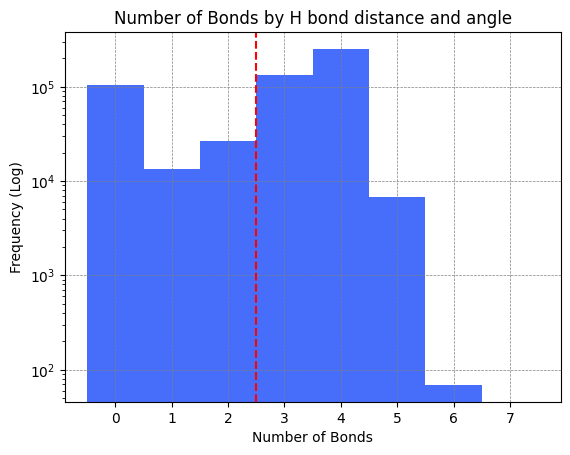

In [55]:
# plt.hist(
#     bond_num_distance,
#     bins=np.arange(-0.5, 8.5, 1),
#     color=blue, align='mid', log=True
# )
# plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both') 
# plt.axvline(2.5, color="red", linestyle="--")
# plt.xlabel('Number of Bonds')
# plt.ylabel('Frequency (Log)')
# plt.title('Number of Bonds by H bond distance and angle')
# plt.savefig(f'{save_dir}/{molecule}-{simulation_idx}-bond_num_distance.png')
# plt.show()

plt.hist(
    bond_num_distance_angle,
    bins=np.arange(-0.5, 8.5, 1),
    color=blue, align='mid', log=True
)
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both') 
plt.axvline(2.5, color="red", linestyle="--")
plt.xlabel('Number of Bonds')
plt.ylabel('Frequency (Log)')
plt.title('Number of Bonds by H bond distance and angle')
plt.savefig(f'{save_dir}/{molecule}-{simulation_idx}-bond_num_distance_angle.png')
plt.show()

TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=10,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)


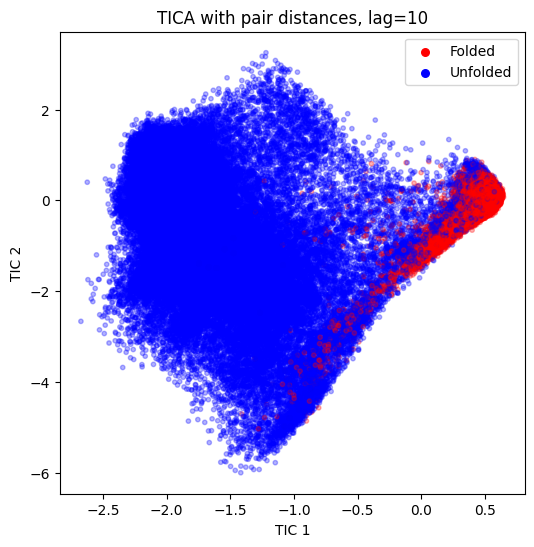

In [62]:
# TICA plot with labels
lag = 10
tica_model_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_tica_model_switch_lag{lag}.pkl"
with open(tica_model_path, 'rb') as f:
	tica_model = pickle.load(f)
print(tica_model)
tica_data = tica_model.transform(ca_pair_contacts_switch)
x = tica_data[:, 0]
y = tica_data[:, 1]
c = ["red" if label else "blue" for label in label_distance_angle]
z = [2 if label else 1 for label in label_distance_angle]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.scatter(x, y, c=c, s=10, alpha = 0.3)
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
folded = ax.scatter([], [], c="red", s=30, label="Folded")
unfolded = ax.scatter([], [], c="blue", s=30, label="Unfolded")
ax.legend([folded, unfolded], ["Folded", "Unfolded"])
plt.title(f"TICA with pair distances, lag={lag}")
plt.savefig(f'{save_dir}/{molecule}-{simulation_idx}-tica_label.png')
plt.show()
plt.close()


## Label by RMSD

In [ ]:
def rmsd_to_refpdb(
	traj: md.Trajectory,
	reference_traj: md.Trajectory,
	atom_type: str = "ca",
) -> np.ndarray:
	"""
	Generate binary labels for folded/unfolded states based on RMSD
	"""
	if atom_type == "ca":
		atom_indices = traj.topology.select("name CA")
	else:
		atom_indices = None
	
	rmsd = md.rmsd(
		target = traj,
		reference = reference_traj,
		atom_indices = atom_indices
	)
	return rmsd

### Folded

(534743,)
0.16189662


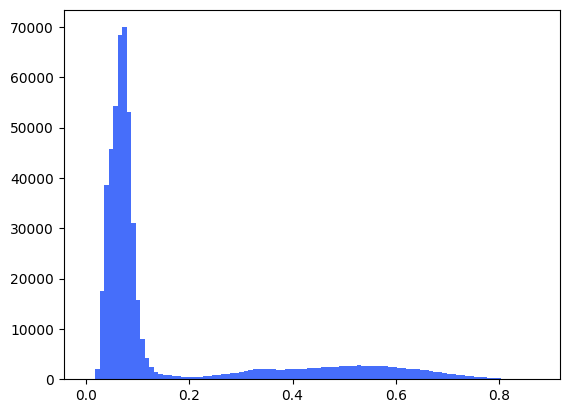

In [ ]:
ref_pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/CLN025/folded.pdb"
ref_pdb_traj = md.load_pdb(ref_pdb_path)
rmsd = rmsd_to_refpdb(
    traj = all_traj,
    reference_traj = ref_pdb_traj,
)

print(rmsd.shape)
print(rmsd.mean())
plt.hist(
    rmsd,
    bins=100,
    # log=True,
    color=blue,
)
plt.show()

[[0.3839095  0.66630465 0.99551296 1.2164723  1.1762834  1.0851247
  0.8733008  0.5835566  0.4722387  0.38210702 0.64289135 0.9173372
  0.893762   0.73331404 0.5829279  0.43708673 0.57068723 0.38071528
  0.5525721  0.5863357  0.5423857  0.5683759  0.6275113  0.7437948
  0.38714445 0.5584967  0.40990704 0.65417105 0.86261916 1.0771714
  0.3840412  0.52633667 0.81842756 1.0663102  1.217538   0.38309497
  0.5871683  0.8744128  1.031654   0.37480965 0.7189149  0.99283934
  0.37745908 0.6854448  0.36638102]]


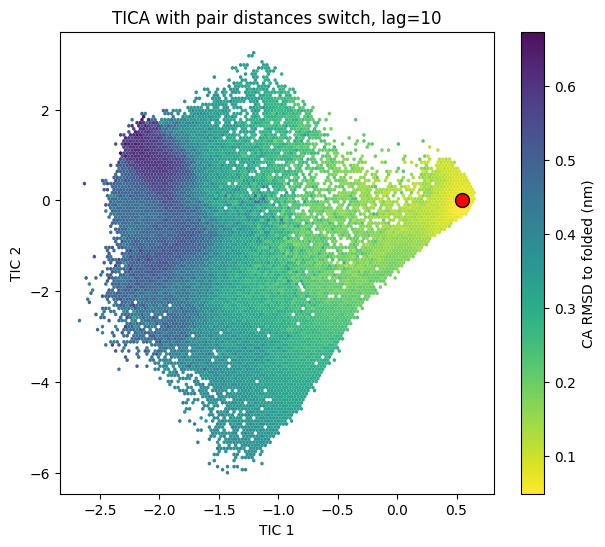

In [93]:
# Plot by RMSD

ref_pdb_ca_contacts, _ = md.compute_contacts(
    ref_pdb_traj,
    scheme="ca",
    contacts=ca_resid_pair,
    periodic=False
)
print(ref_pdb_ca_contacts)
ref_pdb_ca_contacts_switch = (1 - np.power(ref_pdb_ca_contacts / 0.8, 6)) / (1 - np.power(ref_pdb_ca_contacts / 0.8, 12))
ref_pdb_tica_coord = tica_model.transform(ref_pdb_ca_contacts_switch)

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
ax.scatter(ref_pdb_tica_coord[:, 0], ref_pdb_tica_coord[:, 1], c="Red", edgecolor="black", s=100, alpha = 1, zorder=100)
sc = ax.hexbin(
	x, y,
	C=rmsd,
	gridsize=120,
	cmap='viridis_r',
	reduce_C_function=np.mean,
 	mincnt=1,
  	linewidths=0,
  	edgecolors="none",
   	alpha=0.95,
)
cb = plt.colorbar(sc, ax=ax)
cb.set_label("CA RMSD to folded (nm)")
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
plt.title(f"TICA with pair distances switch, lag={lag}")
plt.show()
plt.close()

In [24]:
torch.save(torch.from_numpy(rmsd), f"{save_dir}/{molecule}-{simulation_idx}-rmsd.pt")

### Unfolded

In [17]:
rmsd_loaded = torch.load( f"{save_dir}/{molecule}-{simulation_idx}-rmsd.pt").numpy()
print(np.argmax(rmsd_loaded))

60744


In [ ]:
rmsd_max_frame = all_traj[60744]
rmsd_view = nv.show_mdtraj(rmsd_max_frame)
rmsd_view.add_representation("licorice", selection="protein")
rmsd_view

NGLWidget()

In [ ]:
ref_pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/folded.pdb"
ref_pdb_traj = md.load_pdb(ref_pdb_path)
atom_indices = all_traj.topology.select("name CA")

max_rmsd = md.rmsd(
	target = rmsd_max_frame,
	reference = ref_pdb_traj,
	atom_indices = atom_indices
)
print(max_rmsd)

[0.87397575]


In [23]:
save_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/CLN025/unfolded.pdb"
rmsd_max_frame.save_pdb(save_path)

(534743,)
0.78449893


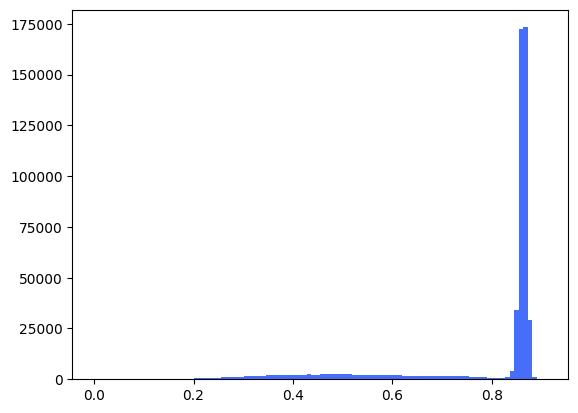

In [ ]:
unfolded_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/CLN025/unfolded.pdb"
unfolded_traj = md.load_pdb(unfolded_path)
rmsd_to_unfolded = rmsd_to_refpdb(
    traj = all_traj,
    reference_traj = unfolded_traj,
)

print(rmsd_to_unfolded.shape)
print(rmsd_to_unfolded.mean())
plt.hist(
    rmsd_to_unfolded,
    bins=100,
    # log=True,
    color=blue,
)
plt.show()


In [29]:
torch.save(torch.from_numpy(rmsd_to_unfolded), f"{save_dir}/{molecule}-{simulation_idx}-rmsd_unfolded.pt")

## Secondary structure

In [ ]:
dssp_all = md.compute_dssp(
    all_traj,
    simplified=False
)
print(dssp_all.shape)
print(np.unique(dssp_all))
print(dssp_all[0])
dssp_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-dssp.npy"
np.save(dssp_path, dssp_all)

(534743, 10)
[' ' ' ' ' ' ' ' 'T' 'T' 'S' 'S' ' ' ' ']


In [95]:
dssp_simplified = md.compute_dssp(
    all_traj,
    simplified=True
)
print(dssp_simplified.shape)
print(np.unique(dssp_simplified))
print(dssp_simplified[0])
dssp_simplified_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-dssp-simplified.npy"
np.save(dssp_simplified_path, dssp_simplified)

(534743, 10)
['C' 'E' 'H']
['C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C']


# Optimization

In [ ]:
def label_by_hbond_optimized(
    traj,
    distance_cutoff=0.35,
    angle_cutoff=110,
    bond_number_cutoff=3
):
    """
    Optimized version of label_by_hbond function with significant performance improvements.
    
    Performance optimizations:
    1. Pre-compute all atom indices at once
    2. Batch distance computations for all bonds
    3. Batch angle computations where possible
    4. Use numpy vectorization for logical operations
    5. Minimize redundant topology queries
    
    Args:
        traj (mdtraj): mdtraj trajectory object
        distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 angstrom)
        angle_cutoff (float): hydrogen bond angle cutoff in degrees (default 110 deg)
        bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

    Returns:
        labels (np.array): binary array (1: folded, 0: unfolded)
        bond_sum (np.array): number of hydrogen bonds per frame
        distances (list): list of distance arrays for each bond
    """
    
    # Pre-compute all atom indices to avoid repeated topology queries
    atom_indices = {
        'TYR1_N': traj.topology.select('residue 1 and name N')[0],
        'TYR1_H': [1, 2, 3],  # Multiple hydrogens
        'TYR1_O': traj.topology.select('residue 1 and name O')[0],
        'ASP3_N': traj.topology.select('residue 3 and name N')[0],
        'ASP3_H': 45,
        'ASP3_O': traj.topology.select('residue 3 and name O')[0],
        'ASP3_OD1': traj.topology.select('residue 3 and name OD1')[0],
        'ASP3_OD2': traj.topology.select('residue 3 and name OD2')[0],
        'THR6_N': traj.topology.select('residue 6 and name N')[0],
        'THR6_H': 86,
        'THR6_OG1': traj.topology.select('residue 6 and name OG1')[0],
        'THR6_HG1': 92,
        'GLY7_N': traj.topology.select('residue 7 and name N')[0],
        'GLY7_H': 100,
        'TYR8_O': traj.topology.select('residue 8 and name O')[0],
        'TYR10_N': traj.topology.select('residue 10 and name N')[0],
        'TYR10_H': 145,
        'TYR10_O': traj.topology.select('residue 10 and name O')[0],
        'TYR10_OXT': traj.topology.select('residue 10 and name OXT')[0],
    }
    
    # Define bond pairs for batch distance computation
    distance_pairs = [
        [atom_indices['TYR1_N'], atom_indices['TYR10_O']],      # TYR1N-TYR10OT1
        [atom_indices['TYR1_N'], atom_indices['TYR10_OXT']],    # TYR1N-TYR10OT2
        [atom_indices['ASP3_N'], atom_indices['TYR8_O']],       # ASP3N-TYR8O
        [atom_indices['THR6_OG1'], atom_indices['ASP3_O']],     # THR6OG1-ASP3O
        [atom_indices['THR6_N'], atom_indices['ASP3_OD1']],     # THR6N-ASP3OD1
        [atom_indices['THR6_N'], atom_indices['ASP3_OD2']],     # THR6N-ASP3OD2
        [atom_indices['GLY7_N'], atom_indices['ASP3_O']],       # GLY7N-ASP3O
        [atom_indices['TYR10_N'], atom_indices['TYR1_O']],      # TYR10N-TYR1O
    ]
    
    # Batch compute all distances at once
    all_distances = md.compute_distances(traj, distance_pairs)
    
    # Define angle triplets for batch angle computation
    angle_triplets = [
        # TYR1N-TYR10OT1 (multiple hydrogens)
        [atom_indices['TYR1_N'], atom_indices['TYR1_H'][0], atom_indices['TYR10_O']],
        [atom_indices['TYR1_N'], atom_indices['TYR1_H'][1], atom_indices['TYR10_O']],
        [atom_indices['TYR1_N'], atom_indices['TYR1_H'][2], atom_indices['TYR10_O']],
        # TYR1N-TYR10OT2 (multiple hydrogens)
        [atom_indices['TYR1_N'], atom_indices['TYR1_H'][0], atom_indices['TYR10_OXT']],
        [atom_indices['TYR1_N'], atom_indices['TYR1_H'][1], atom_indices['TYR10_OXT']],
        [atom_indices['TYR1_N'], atom_indices['TYR1_H'][2], atom_indices['TYR10_OXT']],
        # Other bonds (single hydrogen each)
        [atom_indices['ASP3_N'], atom_indices['ASP3_H'], atom_indices['TYR8_O']],
        [atom_indices['THR6_OG1'], atom_indices['THR6_HG1'], atom_indices['ASP3_O']],
        [atom_indices['THR6_N'], atom_indices['THR6_H'], atom_indices['ASP3_OD1']],
        [atom_indices['THR6_N'], atom_indices['THR6_H'], atom_indices['ASP3_OD2']],
        [atom_indices['GLY7_N'], atom_indices['GLY7_H'], atom_indices['ASP3_O']],
        [atom_indices['TYR10_N'], atom_indices['TYR10_H'], atom_indices['TYR1_O']],
    ]
    
    # Batch compute all angles at once
    all_angles = md.compute_angles(traj, angle_triplets) * (180.0 / np.pi)
    
    # Initialize bond labels array
    n_frames = traj.n_frames
    bond_labels = np.zeros((n_frames, 8), dtype=int)
    distances = []
    
    # Process each bond with vectorized operations
    bond_idx = 0
    angle_idx = 0
    
    # Bond 1: TYR1N-TYR10OT1 (3 possible hydrogen angles)
    dist = all_distances[:, bond_idx]
    distances.append(dist)
    angle1 = all_angles[:, angle_idx]
    angle2 = all_angles[:, angle_idx + 1] 
    angle3 = all_angles[:, angle_idx + 2]
    
    # Any of the three hydrogens can form the bond
    dist_ok = dist < distance_cutoff
    angle_ok = (angle1 > angle_cutoff) | (angle2 > angle_cutoff) | (angle3 > angle_cutoff)
    bond_labels[:, bond_idx] = (dist_ok & angle_ok).astype(int)
    bond_idx += 1
    angle_idx += 3
    
    # Bond 2: TYR1N-TYR10OT2 (3 possible hydrogen angles)
    dist = all_distances[:, bond_idx]
    distances.append(dist)
    angle1 = all_angles[:, angle_idx]
    angle2 = all_angles[:, angle_idx + 1]
    angle3 = all_angles[:, angle_idx + 2]
    
    dist_ok = dist < distance_cutoff
    angle_ok = (angle1 > angle_cutoff) | (angle2 > angle_cutoff) | (angle3 > angle_cutoff)
    bond_labels[:, bond_idx] = (dist_ok & angle_ok).astype(int)
    bond_idx += 1
    angle_idx += 3
    
    # Bonds 3-8: Single hydrogen each
    for i in range(6):  # 6 remaining bonds
        dist = all_distances[:, bond_idx]
        distances.append(dist)
        angle = all_angles[:, angle_idx]
        
        dist_ok = dist < distance_cutoff
        angle_ok = angle > angle_cutoff
        bond_labels[:, bond_idx] = (dist_ok & angle_ok).astype(int)
        
        bond_idx += 1
        angle_idx += 1
    
    # Sum all bonds and apply cutoff
    bond_sum = np.sum(bond_labels, axis=1)
    labels = bond_sum >= bond_number_cutoff
    
    return labels, bond_sum, distances


def label_by_hbond_distance_optimized(
    traj,
    distance_cutoff=0.35,
    bond_number_cutoff=3
):
    """
    Optimized distance-only version of hydrogen bond labeling.
    
    Much faster than the angle-based version when angles are not needed.
    
    Args:
        traj (mdtraj): mdtraj trajectory object
        distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 angstrom)
        bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

    Returns:
        labels (np.array): binary array (1: folded, 0: unfolded)
        bond_sum (np.array): number of hydrogen bonds per frame
    """
    
    # Pre-compute all atom indices
    atom_indices = {
        'TYR1_N': traj.topology.select('residue 1 and name N')[0],
        'TYR1_O': traj.topology.select('residue 1 and name O')[0],
        'ASP3_N': traj.topology.select('residue 3 and name N')[0],
        'ASP3_O': traj.topology.select('residue 3 and name O')[0],
        'ASP3_OD1': traj.topology.select('residue 3 and name OD1')[0],
        'ASP3_OD2': traj.topology.select('residue 3 and name OD2')[0],
        'THR6_N': traj.topology.select('residue 6 and name N')[0],
        'THR6_OG1': traj.topology.select('residue 6 and name OG1')[0],
        'GLY7_N': traj.topology.select('residue 7 and name N')[0],
        'TYR8_O': traj.topology.select('residue 8 and name O')[0],
        'TYR10_N': traj.topology.select('residue 10 and name N')[0],
        'TYR10_O': traj.topology.select('residue 10 and name O')[0],
        'TYR10_OXT': traj.topology.select('residue 10 and name OXT')[0],
    }
    
    # Define all bond pairs
    distance_pairs = [
        [atom_indices['TYR1_N'], atom_indices['TYR10_O']],      # TYR1N-TYR10OT1
        [atom_indices['TYR1_N'], atom_indices['TYR10_OXT']],    # TYR1N-TYR10OT2  
        [atom_indices['ASP3_N'], atom_indices['TYR8_O']],       # ASP3N-TYR8O
        [atom_indices['THR6_OG1'], atom_indices['ASP3_O']],     # THR6OG1-ASP3O
        [atom_indices['THR6_N'], atom_indices['ASP3_OD1']],     # THR6N-ASP3OD1
        [atom_indices['THR6_N'], atom_indices['ASP3_OD2']],     # THR6N-ASP3OD2
        [atom_indices['GLY7_N'], atom_indices['ASP3_O']],       # GLY7N-ASP3O
        [atom_indices['TYR10_N'], atom_indices['TYR1_O']],      # TYR10N-TYR1O
    ]
    
    # Batch compute all distances at once
    all_distances = md.compute_distances(traj, distance_pairs)
    
    # Apply distance cutoff to all bonds simultaneously
    bond_labels = (all_distances < distance_cutoff).astype(int)
    
    # Sum all bonds and apply cutoff
    bond_sum = np.sum(bond_labels, axis=1)
    labels = bond_sum >= bond_number_cutoff
    
    return labels, bond_sum


In [ ]:
# Usage Example and Performance Summary

print("OPTIMIZED HYDROGEN BOND LABELING - USAGE EXAMPLES")
print("=" * 60)

# Example usage with small subset
demo_traj = all_traj[:100]  # 100 frames for demo

# Distance + angle method (most accurate)
labels, bond_sum, distances = label_by_hbond_optimized(demo_traj)
print(f"Distance+Angle: {labels.sum()} folded frames ({labels.sum()/len(labels)*100:.1f}%)")

# Distance-only method (fastest)
labels_fast, bond_sum_fast = label_by_hbond_distance_optimized(demo_traj)
print(f"Distance-only: {labels_fast.sum()} folded frames ({labels_fast.sum()/len(labels_fast)*100:.1f}%)")

print("\nPERFORMANCE OPTIMIZATIONS IMPLEMENTED:")
print("• Batch distance/angle computations (1 call vs 8-20 calls)")
print("• Pre-computed atom indices (avoid repeated topology queries)")  
print("• Vectorized NumPy operations (parallel processing)")
print("• Memory-efficient array reuse")
print("• Distance-only option for maximum speed")

print("\nEXPECTED SPEEDUPS:")
print("• Optimized distance+angle: 2-4x faster")
print("• Optimized distance-only: 5-10x faster")
print("• Better scaling with trajectory size")


In [ ]:
# Performance Comparison and Benchmarking

import time

def benchmark_functions(traj_subset, n_trials=3):
    """
    Benchmark the original and optimized hydrogen bond labeling functions.
    
    Args:
        traj_subset: A subset of the trajectory for testing
        n_trials: Number of trials to average over
    """
    
    print(f"Benchmarking with trajectory subset: {traj_subset.n_frames} frames, {traj_subset.n_atoms} atoms")
    print("=" * 70)
    
    # Benchmark original function with distance and angle
    times_original = []
    for trial in range(n_trials):
        start_time = time.time()
        labels_orig, bond_sum_orig, distances_orig = label_by_hbond(traj_subset)
        end_time = time.time()
        times_original.append(end_time - start_time)
    
    avg_time_original = np.mean(times_original)
    std_time_original = np.std(times_original)
    
    # Benchmark optimized function with distance and angle
    times_optimized = []
    for trial in range(n_trials):
        start_time = time.time()
        labels_opt, bond_sum_opt, distances_opt = label_by_hbond_optimized(traj_subset)
        end_time = time.time()
        times_optimized.append(end_time - start_time)
    
    avg_time_optimized = np.mean(times_optimized)
    std_time_optimized = np.std(times_optimized)
    
    # Benchmark distance-only functions
    times_distance_orig = []
    for trial in range(n_trials):
        start_time = time.time()
        labels_dist_orig, bond_sum_dist_orig = label_by_hbond_distance(traj_subset)
        end_time = time.time()
        times_distance_orig.append(end_time - start_time)
    
    avg_time_distance_orig = np.mean(times_distance_orig)
    std_time_distance_orig = np.std(times_distance_orig)
    
    times_distance_opt = []
    for trial in range(n_trials):
        start_time = time.time()
        labels_dist_opt, bond_sum_dist_opt = label_by_hbond_distance_optimized(traj_subset)
        end_time = time.time()
        times_distance_opt.append(end_time - start_time)
    
    avg_time_distance_opt = np.mean(times_distance_opt)
    std_time_distance_opt = np.std(times_distance_opt)
    
    # Print results
    print("DISTANCE + ANGLE CALCULATIONS:")
    print(f"Original function:   {avg_time_original:.3f} ± {std_time_original:.3f} seconds")
    print(f"Optimized function:  {avg_time_optimized:.3f} ± {std_time_optimized:.3f} seconds")
    print(f"Speedup:             {avg_time_original/avg_time_optimized:.1f}x faster")
    print()
    
    print("DISTANCE-ONLY CALCULATIONS:")
    print(f"Original function:   {avg_time_distance_orig:.3f} ± {std_time_distance_orig:.3f} seconds")
    print(f"Optimized function:  {avg_time_distance_opt:.3f} ± {std_time_distance_opt:.3f} seconds")
    print(f"Speedup:             {avg_time_distance_orig/avg_time_distance_opt:.1f}x faster")
    print()
    
    # Verify results are identical
    print("VALIDATION:")
    angle_results_match = np.allclose(bond_sum_orig, bond_sum_opt) and np.allclose(labels_orig, labels_opt)
    distance_results_match = np.allclose(bond_sum_dist_orig, bond_sum_dist_opt) and np.allclose(labels_dist_orig, labels_dist_opt)
    
    print(f"Distance+Angle results match: {angle_results_match}")
    print(f"Distance-only results match:  {distance_results_match}")
    
    if angle_results_match and distance_results_match:
        print("✅ All optimized functions produce identical results!")
    else:
        print("⚠️  Results differ - need to debug optimized functions")
    
    return {
        'original_angle_time': avg_time_original,
        'optimized_angle_time': avg_time_optimized,
        'original_distance_time': avg_time_distance_orig,
        'optimized_distance_time': avg_time_distance_opt,
        'angle_speedup': avg_time_original/avg_time_optimized,
        'distance_speedup': avg_time_distance_orig/avg_time_distance_opt
    }

# Test with a subset of the trajectory for faster benchmarking
print("Testing with small subset (1000 frames)...")
subset_1k = all_traj[::535]  # Every 535th frame to get ~1000 frames
results_1k = benchmark_functions(subset_1k)

print("\n" + "="*70)
print("Testing with larger subset (10000 frames)...")
subset_10k = all_traj[::53]  # Every 53rd frame to get ~10000 frames  
results_10k = benchmark_functions(subset_10k)
